This notebook looks at the random effects multinomial logistic regression. The simpleset case is just one grouping variable and three levels (2 levels would just be a binary logistic regression). The model is:

TODO: add priors and such
$$
\log \left( \frac{p_{ij}}{p_{i1}} \right) = \beta_j + u_{ij}  
$$

where $p_{ij}$ is the probability of the $j$ th outcome for the $i$ th group and $u_{ij}$ is the random effect for the $i$ th group.

The random effects are assumed to be normally distributed with mean 0 and covariance matrix $\Sigma_u$

If we consider the random effect as a hidden latent variable, one per observation (aggregate counts), this is can be used instead of Dirichlet-multinomial regression to model overdispersed multinomial data. In that case when looking at posterior predictions, it is important to always use a 'new group' to get overdispersion.  )

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.special import softmax
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb
import arviz as az
import pytensor.tensor as pt

np.random.seed(33)

# Settings
num_groups = 100
num_categories = 3  # categories: 0 (pivot), 1, 2 minimal non-trivial 
 
# mean effect is zero, but we could set it to something else
mean_effect = np.zeros(num_categories - 1)

corr_effect = np.array([
    [1.0, 0.7],
    [0.7, 1.0]
])

sds = [0.5, 1.0]

cov_effect = np.diag(sds) @ corr_effect @ np.diag(sds)

 

group_effects = multivariate_normal.rvs(mean=mean_effect, cov=cov_effect, size=num_groups)
# Add pivot logits = 0
group_effects = np.hstack([np.zeros((num_groups, 1)), group_effects])

# Store group random effects in a DataFrame
group_ids = [f'group_{i}' for i in range(num_groups)]
group_effects_df = pd.DataFrame(group_effects, columns=[f'logit_{i}' for i in range(num_categories)])
group_effects_df['group'] = group_ids

# Generate observations per group
data = []
for idx, group in enumerate(group_ids):
    n_obs = np.random.poisson(30)  #  average 30 observations per group
    
  
    logits = group_effects[idx]
    probs = softmax(logits)
    for obs in range(n_obs):
          
        observed_cat = np.random.choice(num_categories, p=probs)
        
        # Append observation
        data.append({
            'group': group,
            'group_id' : idx,
            'cat': f'cat_{observed_cat}',
            'cat_id': observed_cat,
        })

# Convert to DataFrame
simulated_df = pd.DataFrame(data)


print(simulated_df.head(10))


     group  group_id    cat  cat_id
0  group_0         0  cat_1       1
1  group_0         0  cat_2       2
2  group_0         0  cat_0       0
3  group_0         0  cat_1       1
4  group_0         0  cat_1       1
5  group_0         0  cat_2       2
6  group_0         0  cat_2       2
7  group_0         0  cat_1       1
8  group_0         0  cat_0       0
9  group_0         0  cat_1       1


In [2]:
cov_effect

array([[0.25, 0.35],
       [0.35, 1.  ]])

Check empirical covariance of logits

In [3]:
 
emp_cov = np.cov(group_effects[:,1:].T)
print(emp_cov)


[[0.25635594 0.37392667]
 [0.37392667 1.13115093]]


We can try to use bambi here, but it doesn't support correlated random effects in this case. It doesnt even estimate a different random effect for each log_odds. In BRMS we can do it with `(1|ID|group)` syntax. I dont believe bambi has a simular feature. Best we can do is to estimate uncorrelated effects.

In [6]:
 

model = bmb.Model('cat ~  (1| group)', data=simulated_df, family='categorical')
results = model.fit()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|group_sigma, 1|group_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [7]:
 
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[cat_1],-0.078,0.081,-0.223,0.077,0.002,0.001,2372.0,2643.0,1.00
Intercept[cat_2],0.102,0.079,-0.045,0.253,0.002,0.001,2381.0,2769.0,1.00
1|group_sigma,0.651,0.055,0.555,0.757,0.002,0.001,1202.0,1713.0,1.01
"1|group[cat_1, group_0]",0.172,0.359,-0.521,0.820,0.004,0.006,6905.0,2647.0,1.00
"1|group[cat_1, group_1]",0.046,0.416,-0.741,0.828,0.005,0.008,6448.0,2696.0,1.00
...,...,...,...,...,...,...,...,...,...
"1|group[cat_2, group_95]",0.751,0.338,0.146,1.416,0.004,0.006,5802.0,2818.0,1.00
"1|group[cat_2, group_96]",0.201,0.416,-0.599,0.956,0.005,0.007,5844.0,2864.0,1.00
"1|group[cat_2, group_97]",0.601,0.383,-0.133,1.301,0.005,0.006,5907.0,3232.0,1.00
"1|group[cat_2, group_98]",0.041,0.351,-0.646,0.678,0.004,0.006,6649.0,3281.0,1.00


The model we really want looks like this:

In [4]:
# categorical model
num_obs = simulated_df.shape[0]

with pm.Model() as model:
     
    group_idx = pm.Data("group_idx", simulated_df["group_id"].values)
    cat_obs = pm.Data("cat_obs", simulated_df["cat_id"].values)
    sd_dist = pm.HalfStudentT.dist(nu=3, sigma=10)
    
    chol_cov,_, _ = pm.LKJCholeskyCov(
        "chol_cov",
        n=num_categories - 1,
        eta=1,
         sd_dist=sd_dist
    )

    z = pm.Normal(
        "z",
        0, 1,
        shape=(num_groups, num_categories - 1)
    )

    group_effects_m = pm.Deterministic(
        "group_effects",
        pt.dot(z, chol_cov.T), 
    )

    mean_effect = pm.Normal(
        "mean_effect",
        0, 1,
        shape=(num_categories - 1)
    )


    group_eff_obs = group_effects_m[group_idx, :]  # (num_obs, num_categories - 1)

    logits = pt.concatenate(
        [pt.zeros((num_obs, 1)), group_eff_obs + mean_effect],
        axis=1
    ) 

    
    pm.Categorical("obs", logit_p=logits, observed=cat_obs)

    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, z, mean_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [5]:
az.summary(trace, var_names = ["~z","~group_effects"])

c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_effect[0],-0.005,0.064,-0.124,0.116,0.001,0.001,3061.0,2810.0,1.0
mean_effect[1],0.106,0.113,-0.105,0.317,0.002,0.002,3329.0,2786.0,1.0
chol_cov[0],0.400,0.071,0.270,0.534,0.002,0.001,1691.0,3012.0,1.0
chol_cov[1],0.781,0.137,0.529,1.044,0.005,0.003,886.0,1420.0,1.0
chol_cov[2],0.566,0.130,0.322,0.814,0.005,0.004,784.0,933.0,1.0
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
"chol_cov_corr[0, 1]",0.796,0.100,0.619,0.981,0.004,0.003,746.0,937.0,1.0
"chol_cov_corr[1, 0]",0.796,0.100,0.619,0.981,0.004,0.003,746.0,937.0,1.0
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3757.0,3539.0,1.0
chol_cov_stds[0],0.400,0.071,0.270,0.534,0.002,0.001,1691.0,3012.0,1.0


In [6]:
dat = az.extract(trace, group = 'posterior', var_names = ["chol_cov_corr","chol_cov_stds"], combined = True)
corr = dat["chol_cov_corr"].values
stds = dat["chol_cov_stds"].values[:,None,:]
covariances =  corr * stds * stds.transpose(1, 0, 2) 
mean_covariance = np.mean(covariances, axis=2)

print(mean_covariance)

[[0.16521333 0.31493019]
 [0.31493019 0.96695628]]


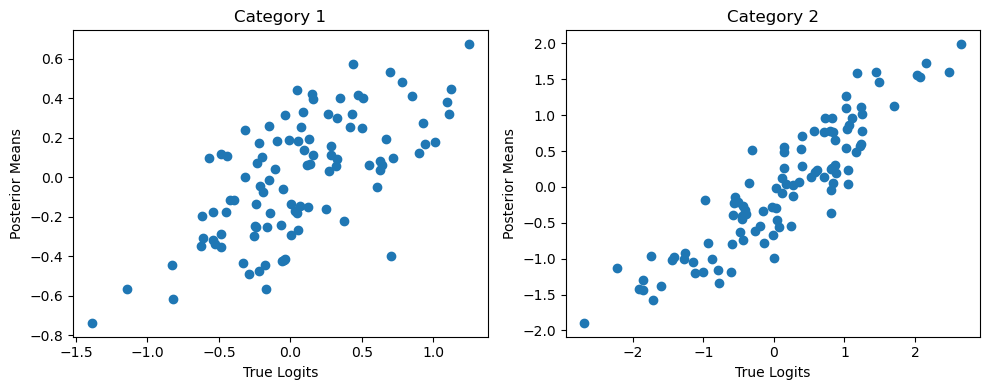

In [11]:
 
true_effects = group_effects[:, 1:]  # exclude baseline logits

 
posterior_means = trace.posterior["group_effects"].mean(dim=["chain", "draw"]).values

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    axes[i].scatter(true_effects[:, i], posterior_means[:, i])
    axes[i].set_xlabel("True Logits")
    axes[i].set_ylabel("Posterior Means")
    axes[i].set_title(f"Category {i+1}")

plt.tight_layout()
plt.show()


## Group into aggregated data

In [8]:
agg_df = (
    simulated_df[["group_id","cat"]]
        .groupby(["group_id","cat"])
        .size()
        .reset_index()
        .pivot(index = "group_id", columns = "cat", values = 0)
        .fillna(0)
        .assign(total = lambda x:x.cat_0+ x.cat_1 + x.cat_2)
        .reset_index() # pandas please

).astype(int)
agg_df.sample(20)

cat,group_id,cat_0,cat_1,cat_2,total
28,28,15,11,14,40
50,50,8,6,3,17
3,3,9,10,14,33
98,98,10,11,12,33
89,89,11,7,7,25
90,90,14,12,7,33
6,6,9,4,16,29
59,59,0,9,19,28
5,5,8,12,13,33
76,76,14,9,2,25


Bambi doesnt yet support multinomial logistic regression at all, but we can do this in pymc.

In [9]:
 

with pm.Model() as model:
     
    group_idx = pm.Data("group_idx", agg_df["group_id"].values)
    count_obs = pm.Data("count_obs", agg_df[["cat_0","cat_1","cat_2"]].values) # 3x num_groups
    total_obs = pm.Data("total_obs", agg_df["total"].values) # num_groups


    sd_dist = pm.HalfStudentT.dist(nu=3, sigma=10)
    
    chol_cov,_, _ = pm.LKJCholeskyCov(
        "chol_cov",
        n=num_categories - 1,
        eta=1,
         sd_dist=sd_dist
    )

    z = pm.Normal(
        "z",
        0, 1,
        shape=(num_groups, num_categories - 1)
    )

    group_effects_m = pm.Deterministic(
        "group_effects",
        pt.dot(z, chol_cov.T), 
    )

    mean_effect = pm.Normal(
        "mean_effect",
        0, 1,
        shape=(num_categories - 1)
    )


    group_eff_obs = group_effects_m[group_idx, :]  # (num_groups, num_categories - 1)

    logits = pt.concatenate(
        [pt.zeros((num_groups, 1)), group_eff_obs + mean_effect],
        axis=1
    ) 

    # Pymc doesnt support logit_p in multinomial
    p = pm.math.softmax(logits, axis=1)   

    
    pm.Multinomial("obs", p=p, n=total_obs , observed=count_obs)

    trace = pm.sample(idata_kwargs={"log_likelihood": True})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, z, mean_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
az.summary(trace, var_names = ["~z","~group_effects"])

c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_effect[0],-0.006,0.062,-0.126,0.106,0.001,0.001,3074.0,2634.0,1.00
mean_effect[1],0.107,0.109,-0.079,0.339,0.002,0.002,3024.0,2503.0,1.00
chol_cov[0],0.396,0.071,0.266,0.533,0.002,0.001,1979.0,2164.0,1.00
chol_cov[1],0.782,0.138,0.521,1.031,0.006,0.002,608.0,1439.0,1.01
chol_cov[2],0.557,0.140,0.286,0.806,0.007,0.005,486.0,499.0,1.01
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
"chol_cov_corr[0, 1]",0.799,0.103,0.620,0.995,0.005,0.002,443.0,552.0,1.01
"chol_cov_corr[1, 0]",0.799,0.103,0.620,0.995,0.005,0.002,443.0,552.0,1.01
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3820.0,3627.0,1.00
chol_cov_stds[0],0.396,0.071,0.266,0.533,0.002,0.001,1979.0,2164.0,1.00


In [11]:
dat = az.extract(trace, group = 'posterior', var_names = ["chol_cov_corr","chol_cov_stds"], combined = True)
corr = dat["chol_cov_corr"].values
stds = dat["chol_cov_stds"].values[:,None,:]
covariances =  corr * stds * stds.transpose(1, 0, 2) 
mean_covariance = np.mean(covariances, axis=2)

print(mean_covariance)

[[0.1621778  0.31149575]
 [0.31149575 0.96054296]]


Posterior checking

In [12]:
with model:
    ppc = pm.sample_posterior_predictive(trace)


Sampling: [obs]


Output()

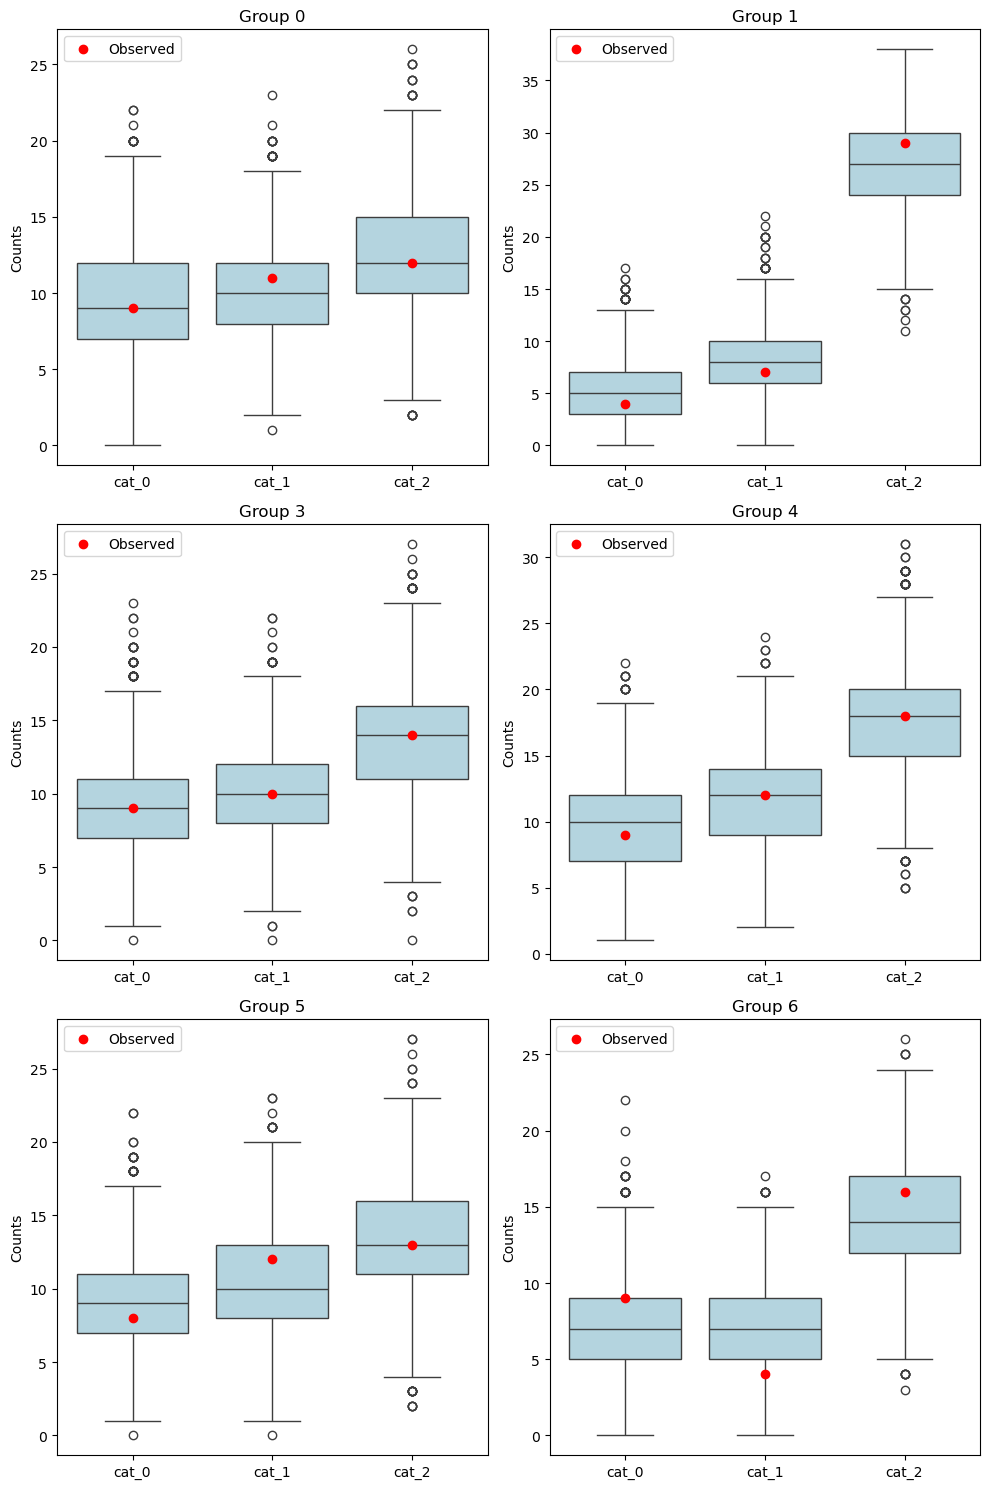

In [13]:

import seaborn as sns


selected_groups = [0, 1, 3, 4,5,6]
num_selected = len(selected_groups)

all_pp_counts = az.extract(
    ppc, group="posterior_predictive", var_names=["obs"], combined=True
)
pp_counts = all_pp_counts[selected_groups, :, :].values  # (num_groups, num_categories, num_samples)

# observed counts for comparison
obs_counts = agg_df.loc[selected_groups, ["cat_0", "cat_1", "cat_2"]].values

fig, axes = plt.subplots(num_selected // 2, 2, figsize=(10, 2.5 * num_selected))
axes = axes.flatten() if num_selected > 1 else [axes]
categories = ["cat_0", "cat_1", "cat_2"]

for idx, group in enumerate(selected_groups):
    ax = axes[idx]

    # Prepare data for seaborn boxplot
    data = [pp_counts[idx, cat_idx, :] for cat_idx in range(len(categories))]
    sns.boxplot(data=data, ax=ax, color='lightblue')

    # Overlay observed data
    ax.scatter(range(len(categories)), obs_counts[idx], color='red', zorder=5, label='Observed')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)
    ax.set_title(f'Group {group}')
    ax.set_ylabel('Counts')
    ax.legend()

plt.tight_layout()
plt.show()


<Axes: xlabel='obs'>

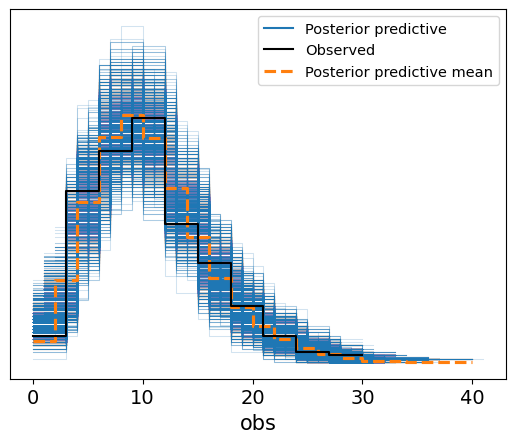

In [14]:
az.plot_ppc(ppc, group = "posterior")

## Try direchlet-multinomial

In [15]:

with pm.Model() as dm_model:
    
    group_idx = pm.Data("group_idx", agg_df["group_id"].values)
    count_obs = pm.Data("count_obs", agg_df[["cat_0","cat_1","cat_2"]].values)
    total_obs = pm.Data("total_obs", agg_df["total"].values)
    
    num_categories = count_obs.shape[1]

    concentration = pm.HalfNormal('concentration', sigma=5, shape=num_categories) #prior for Dirichlet
    group_alpha = pm.Dirichlet('group_alpha', a=concentration, shape=(agg_df["group_id"].nunique(), num_categories))
    
    
    
    pm.DirichletMultinomial('obs', a=group_alpha[group_idx] , n=total_obs, observed=count_obs)
    
    dm_trace = pm.sample(idata_kwargs={"log_likelihood": True})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [concentration, group_alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Sampling: [obs]


Output()

<Axes: xlabel='obs'>

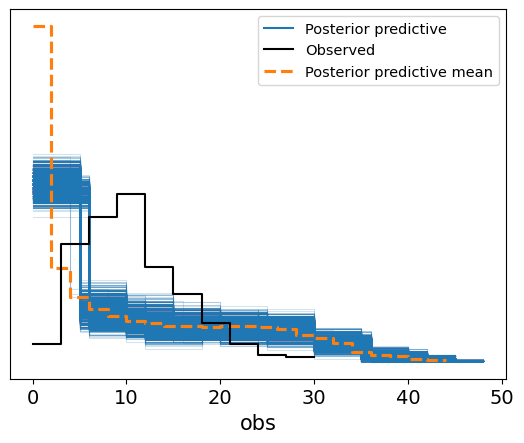

In [16]:
with dm_model:
    dm_ppc = pm.sample_posterior_predictive(dm_trace)

az.plot_ppc(dm_ppc)

In [17]:
import seaborn as sns

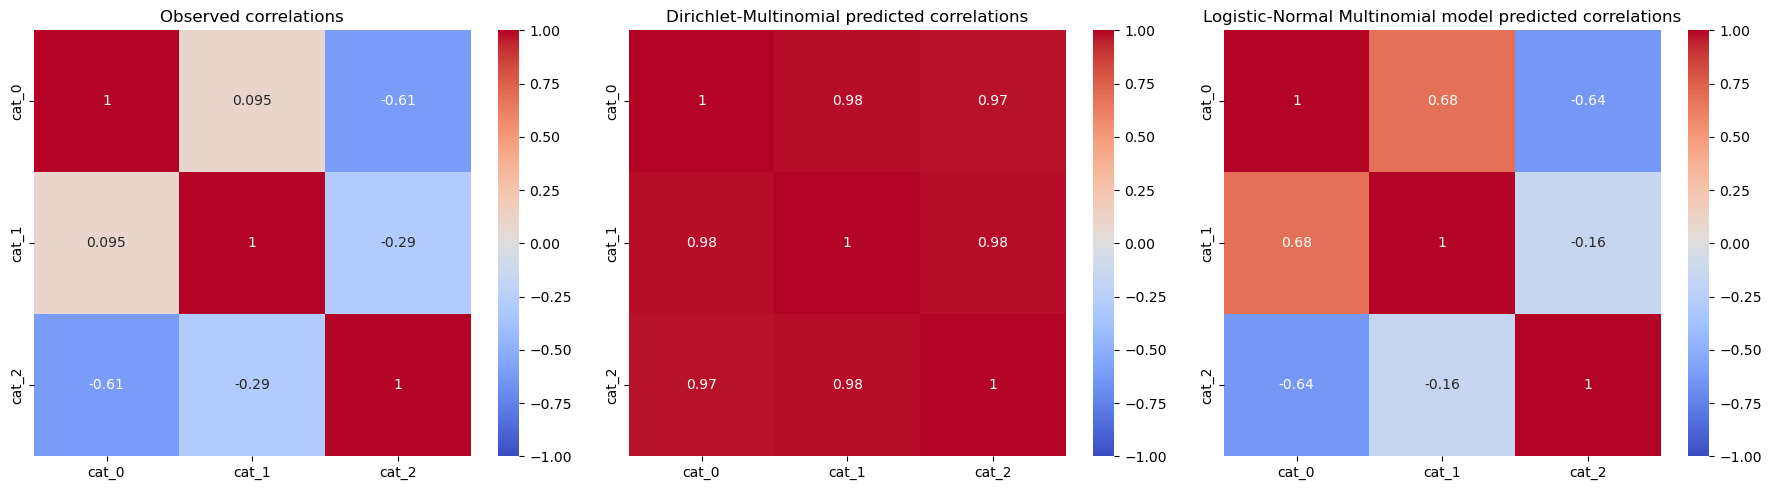

In [30]:
# Observed correlation
obs_counts = agg_df[["cat_0", "cat_1", "cat_2"]].values
obs_corr = np.corrcoef(obs_counts.T)

# Dirichlet-Multinomial posterior predictive extraction
dm_pred_obs = az.extract(dm_ppc, group="posterior_predictive", var_names=["obs"], combined=True)
dm_ppc_means = dm_pred_obs.mean(axis=2)
dm_ppc_corr = np.corrcoef(dm_ppc_means.T)

# Logistic model posterior predictive extraction
logistic_pred_obs = az.extract(ppc, group="posterior_predictive", var_names=["obs"], combined=True)
logistic_ppc_means = logistic_pred_obs.mean(axis=2)
logistic_ppc_corr = np.corrcoef(logistic_ppc_means.T)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(obs_corr, annot=True, xticklabels=categories, yticklabels=categories,
            ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Observed correlations')

sns.heatmap(dm_ppc_corr, annot=True, xticklabels=categories, yticklabels=categories,
            ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Dirichlet-Multinomial predicted correlations')

sns.heatmap(logistic_ppc_corr, annot=True, xticklabels=categories, yticklabels=categories,
            ax=axes[2], cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title('Logistic-Normal Multinomial model predicted correlations')

plt.tight_layout()
plt.show()


c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

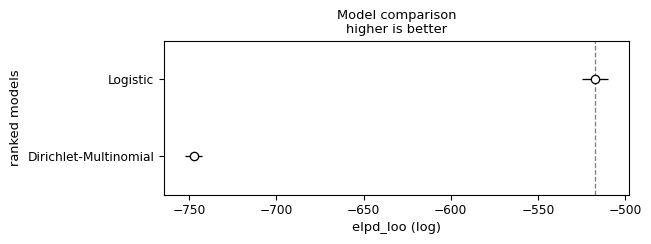

In [20]:
loo_logistic = az.loo(trace)
loo_dm = az.loo(dm_trace)

comparison = az.compare({'Logistic': loo_logistic, 'Dirichlet-Multinomial': loo_dm})

az.plot_compare(comparison)
